In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 20px; }</style>"))

# Theory Computing - Neutron Stars: Notebook 3
<div style="text-align: right"> Jude McClay and Rasheed Miladi </div>

$\frac{dp}{dr} = -\frac{G\rho (r) M(r)}{r^2} = -\frac{G\epsilon (r) M(r)}{c^2 r^2}$ (1)

$\frac{dM}{dr} = 4\pi r^2 \rho (r) = \frac{4\pi r^2 \epsilon (r)}{c^2}$ (2)

$\epsilon (r) = \rho (r) c^2$

Tolman-Oppenheimer-Volkov (TOV) equation:

$\frac{dp}{dr} = -\frac{G\epsilon (r) M(r)}{c^2r^2} \left[1 + \frac{p(r)}{\epsilon(r)} \right] \left[1 + \frac{4\pi r^3 p(r)}{M(r) c^2} \right] \left[1 - \frac{2GM(r)}{c^2 r}\right]^{-1}$

This can be rewritten to avoid (apparent) singularities in $M(r)$:

$\frac{dp}{dr}= -\frac{G}{r^2}\left[\frac{\epsilon(r) + p(r)}{c^2}\right]
\left[\mathrm{M}_{\odot} \bar{M}(r) + \frac{4\pi r^3 p(r)}{c^2} \right]
\left[1 - \frac{2G\mathrm{M}_{\odot}\bar{M}(r)}{c^2 r}\right]^{-1}$ (3)

$K_{rel} = \frac{\hbar c}{12\pi^2}(\frac{3\pi^2 Z}{m_N c^2 A})^{\frac{4}{3}}$

or

$K_{non-rel} = \frac{\hbar^2}{15\pi^2 m_e}(\frac{3\pi^2 Z}{Am_n c^2})^{\frac{5}{3}}$

where $Z$ is the Proton number and $A$ is the Atomic Mass number. For a star predominantly composed of $^{12}C$, the ratio $\frac{Z}{A} = \frac{1}{2}$.

$\bar{M}(r) = \frac{M(r)}{M_{\odot}}$, so we can rewrite Equation 1 as:

For a polytrope,

$p = K\epsilon^{\gamma}$,



In [4]:
"""
Import all necessary packages:
"""
from platform import python_version

print(python_version())
import scipy
print(scipy.__version__)
import numpy as np
import scipy.linalg as lg
import matplotlib.pyplot as plt
from scipy import constants
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline

from matplotlib import rc
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"

rcParams['figure.dpi'] = 100
%matplotlib inline


from IPython.display import Latex, display

3.7.3
1.4.1


In [5]:
"""
Define all necessary physical constants:
"""

G = constants.gravitational_constant # 6.67 * 10^-11 m**3 kg**-1 s**-2
c = constants.speed_of_light # 299,792,458 m s^-1
h_bar = constants.hbar #J s
m_n = constants.m_n #kg
m_e = constants.m_e #kg
Z_by_A = 1/2 # = 1 for a pure neutron star

gamma = 5/3

epsilon_0 = ((m_e**4 * c**5) / (np.pi**2 * h_bar**3))
print(epsilon_0)
solar_mass = 1.98855 * 10**30 #kg


#K = ((h_bar * c)/(12 * (np.pi)**2))*((3 * (np.pi)**2 * Z_by_A)/(m_n * c**2))**(4/3) #K_rel (J m**(-3))**(-1/3)
#K = 1.211771313 * 10**-13 #K_rel: 

#K = 1.7239577222 * 10**-22 #K_non-rel: 
K = ((h_bar**2)/(15 * (np.pi)**2 * m_e)) * ((3 * (np.pi**2) * Z_by_A)/(m_n * c**2))**(5/3) #K_non-rel (J m**(-3))**(-2/3)

#CHANGE m_e to m_n for pure neutron star ^


1.4405597245585048e+23


Notes:

$\frac{Z}{A}$ (defined as 'Z_by_A' above) is the ratio of proton (and therefore electron) number to the total number of nucleons. In the case of a pure neutron star, since we are modelling it as a pure neutron Fermi gas rather than an electron Fermi gas, we are interested in the number of neutrons, and the number of neutrons per nucleon is 1, so $\frac{Z}{A} = 1$.

When considering a pure neutron star, the electron masses, $m_e$, in the expressions for $K$ should be replaced with neutron masses, $m_n$.

I am using SI units for all calculations to keep things uniform.

All functions necessary for the numerical solving process and defined in the following few cells.
The user can choose whether or not they wish to use the Newtonian equations, or the equation with
the GR corrections, by changing which function is being used by the solver. The user can also 
choose whether to use a polytropic approximation, or a more rigorous method, for the equation of
state of the star, $\epsilon(p)$.

1. Polytropic Approximation:

A simple approximation, given by $p = K\epsilon^{\gamma}$, or conversely, $\epsilon = (\frac{p}{K})^{\frac{1}{\gamma}}$.

In [6]:
def epsilon_polytrope(p):
    """
    Returns the polytropic relation between energy density and pressure:
    e = (p/K)^(1/gamma).
    """
    return np.power(((p) / K), (1. / gamma))

2. A more accurate method: 

Uses a root-finding method to calculate the $k_F$ value corresponding to a given pressure, and plug
that into the expression for $\epsilon_{elec}$. Finally add it to the neutron contribution to the
energy density to find the total energy density. 
Unfortunately, this method did not work very well due to Python have issues with calculating
accurate values for the pressure at very small $x$ values $(x << 1)$.

In [7]:
def function(x, p):
    
    return ((1 / 24) * ((2*x**3 - 3*x) * (1 + x**2)**(1/2) + 3*np.arcsinh(x)) - p/epsilon_0)

def pressure(x):
    
    return (epsilon_0 / 24) * ((2*x**3 - 3*x) * (1 + x**2)**(1/2) + 3*np.arcsinh(x))

def n(x):
    
    return ((m_e * c * x)**3)/(3 * np.pi**2 * h_bar**3)

def epsilon_elec(x):
    """
    Returns the contribution to the total energy density due to electrons
    
    x == k_f/(m_e * c) 
    """
    return (epsilon_0 / 8) * ((2*x**3 + x) * (1 + x**2)**(1/2) - np.arcsinh(x))

def epsilon(x):
    return ((n(x) * m_n * c**2) / (Z_by_A)) + epsilon_elec(x)

def EoS_e(p):
    
    solution = optimize.root_scalar(function, args = (p,), method = 'brentq', bracket = [0, 10**20], rtol = 10**-15)
    x = solution.root
    epsilon_value = epsilon(x)
    
    return epsilon_value


3. A slightly less efficient, but functional method: 

Instead, we will create an array of $x$ values, and compute the corresponding pressures and energy densities. We will then use spline interpolation to smooth out the function (only important for $x << 1$, but will be applied over the entire range for simplicity), which will generate a smooth, continuous function relating the energy density and the pressure, which can then be used by the solver.

In [8]:
x_values_0 = np.array([0, 1.701e-4, 1.8e-4, 1.9e-4, 1.99e-4, 2.05e-4])
x_values_1 = np.arange(2.5e-4, 1e-3, 2e-5)
x_values_2 = np.arange(1e-3, 1e0, 1e-5)
x_values_3 = np.arange(1e0, 1e3, 1e-2)
x_values_4 = np.arange(1e3, 1e6, 1e1)

x_values = x_values_0
x_values = np.append(x_values, x_values_1)
x_values = np.append(x_values, x_values_2)
x_values = np.append(x_values, x_values_3)
x_values = np.append(x_values, x_values_4)

pressure_values = pressure(x_values)
epsilon_values = epsilon(x_values)

spl = make_interp_spline(pressure_values, epsilon_values, k = 3)

def epsilon_smooth(p):
    
    return spl(p)

Below are the two differential equations for $\frac{dp}{dr}$ and $\frac{dM}{dr}$, along with a event function which checks, at each step in the numerical integration carried out, whether or not the pressure has reached $0$. If so, the integration is halted.

In [9]:
def differential_equations_non_rel(r, y): 
    """
    Returns the right hand sides of the two non-relativistic
    differential Equations 1 and 2 above.
    
    r ---- r values (units of m)
    y ---- array: 
        
        y[0] --- p (pressure in Pa)
        y[1] --- M_bar (dimensionless mass [units of solar masses]).
    """
    p, M = y
                  
    dpdr = -((G * solar_mass)/(c**2) * epsilon_smooth(p) * M)/(r**2)
    
    dMdr = ((4 * np.pi)/(solar_mass * c**2)) * epsilon_smooth(p) * r**2
    
    return[dpdr, dMdr]

def differential_equations_non_rel_poly(r, y): 
    """
    Returns the right hand sides of the two non-relativistic
    differential Equations 1 and 2 above.
    
    r ---- r values (units of m)
    y ---- array: 
        
        y[0] --- p (pressure in Pa)
        y[1] --- M_bar (dimensionless mass [units of solar masses]).
    """
    p, M = y
                  
    dpdr = -((G * solar_mass)/(c**2) * epsilon_polytrope(p) * M)/(r**2)
    
    dMdr = ((4 * np.pi)/(solar_mass * c**2)) * epsilon_polytrope(p) * r**2
    
    return[dpdr, dMdr]


def differential_equations_GR(r, y): 
    """
    Returns the right hand sides of the two differential Equations 2 and 3
    above. These equations incorporate the General Relativistic corrections
    of the Tolman-Oppenheimer-Volkov Equation (given by Equation 3).
    
    r ---- r values (units of m)
    y ---- array: 
        
        y[0] --- p (pressure in Pa)
        y[1] --- M_bar (dimensionless mass [units of solar masses]).
    """
    p, M = y
        
    dpdr = -(G/r**2) * (solar_mass * M + (4 * np.pi * r**3 * p)/(c**2)) \
    * ((epsilon_smooth(p) + p)/(c**2)) * (1 - ((2 * G * solar_mass * M)/(r * c**2)))**(-1)
        
    dMdr = ((4 * np.pi)/(solar_mass * c**2)) * epsilon_smooth(p) * r**2
    
    return[dpdr, dMdr]

def reach_zero(r, y):
    """
    Returns the value of p at each point.
    """
    return y[0] - 1e0

reach_zero.terminal = True #terminates integration when p_bar = 0.

In [10]:
"""
Initial conditions:
"""

r_0 = 1e-40 # metres: tiny, but non-zero starting radius to avoid Python trying to compute 0 divided by 0.
r_max = 7e7 # metres (when to stop)

p_0 = 1e20 #Pa (1 dyne/cm^2 = 0.1 N/m^2)
m_0 = 0 #Solar Masses - starting at (essentially) the centre of the star, there is no mass enclosed.
z_0 = [p_0, m_0] #Initial conditions for pressure and mass

r_span = (r_0, r_max)

In [11]:
"""
Run the solver, collect the results and find the p-intercept,
which defines the radius and mass of the star.
"""

results = solve_ivp(differential_equations_non_rel, r_span, z_0, max_step = 10000, events = reach_zero)
print(results.message)

print('last p, m = ', results.y[:, -1], 'for r_event=', results.t_events)
r_values = results.t

p_values = results.y[0, :]
M_values = results.y[1, :]

results_2 = solve_ivp(differential_equations_non_rel_poly, r_span, z_0, max_step = 1000, events = reach_zero)
print(results_2.message)

print('last p, m = ', results_2.y[:, -1], 'for r_event=', results_2.t_events)
r_values_2 = results_2.t

p_values_2 = results_2.y[0, :]
M_values_2 = results_2.y[1, :]

#print(p_values_second)

A termination event occurred.
last p, m =  [1.         0.16508144] for r_event= [array([15510481.37331294])]
A termination event occurred.
last p, m =  [1.00000001 0.17301964] for r_event= [array([15705792.58976302])]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

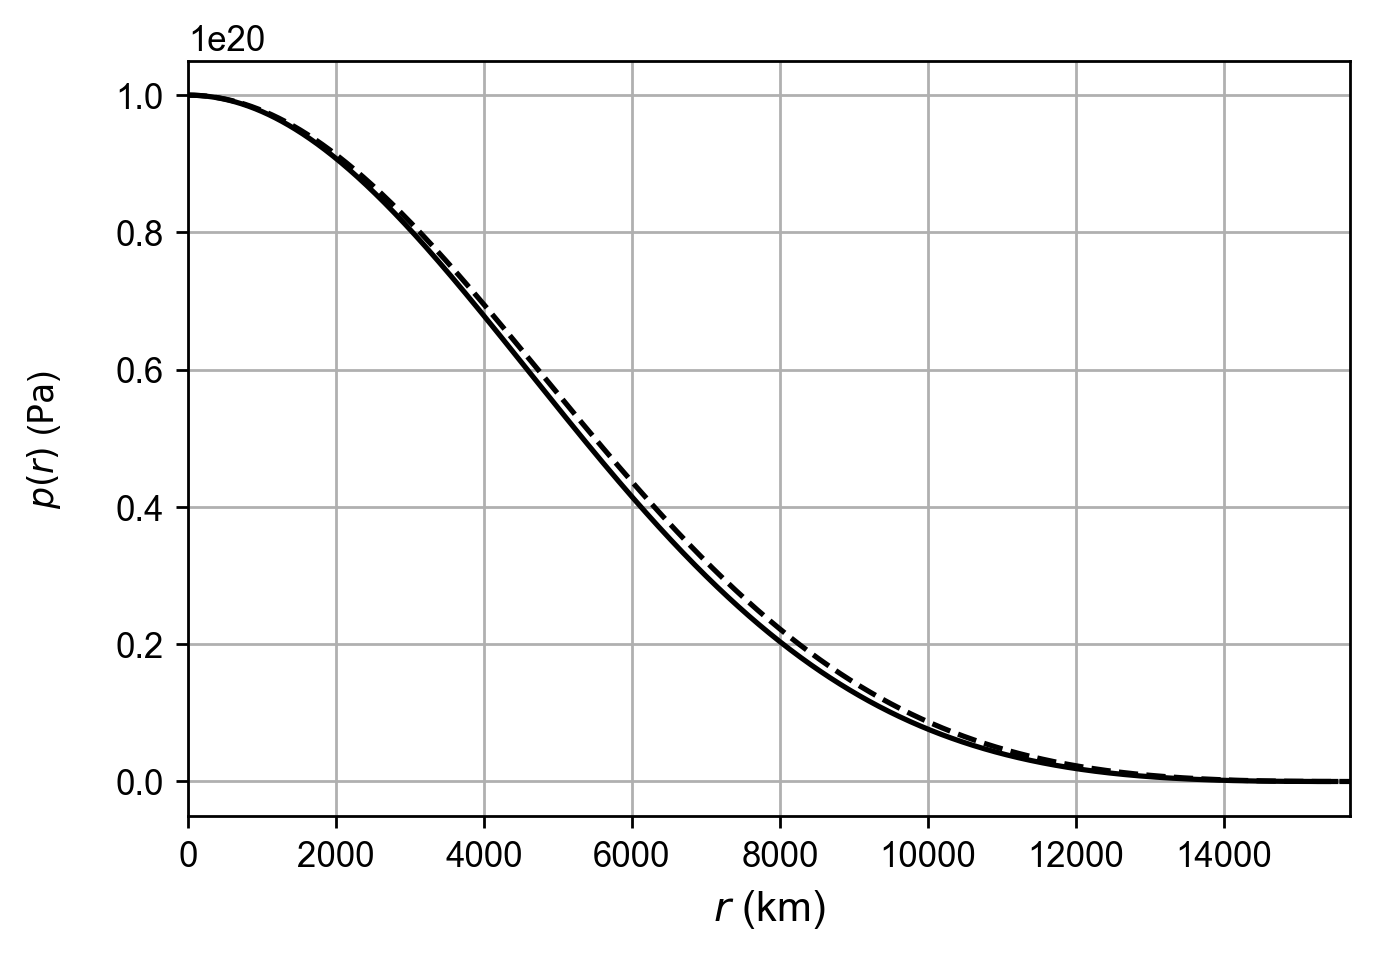

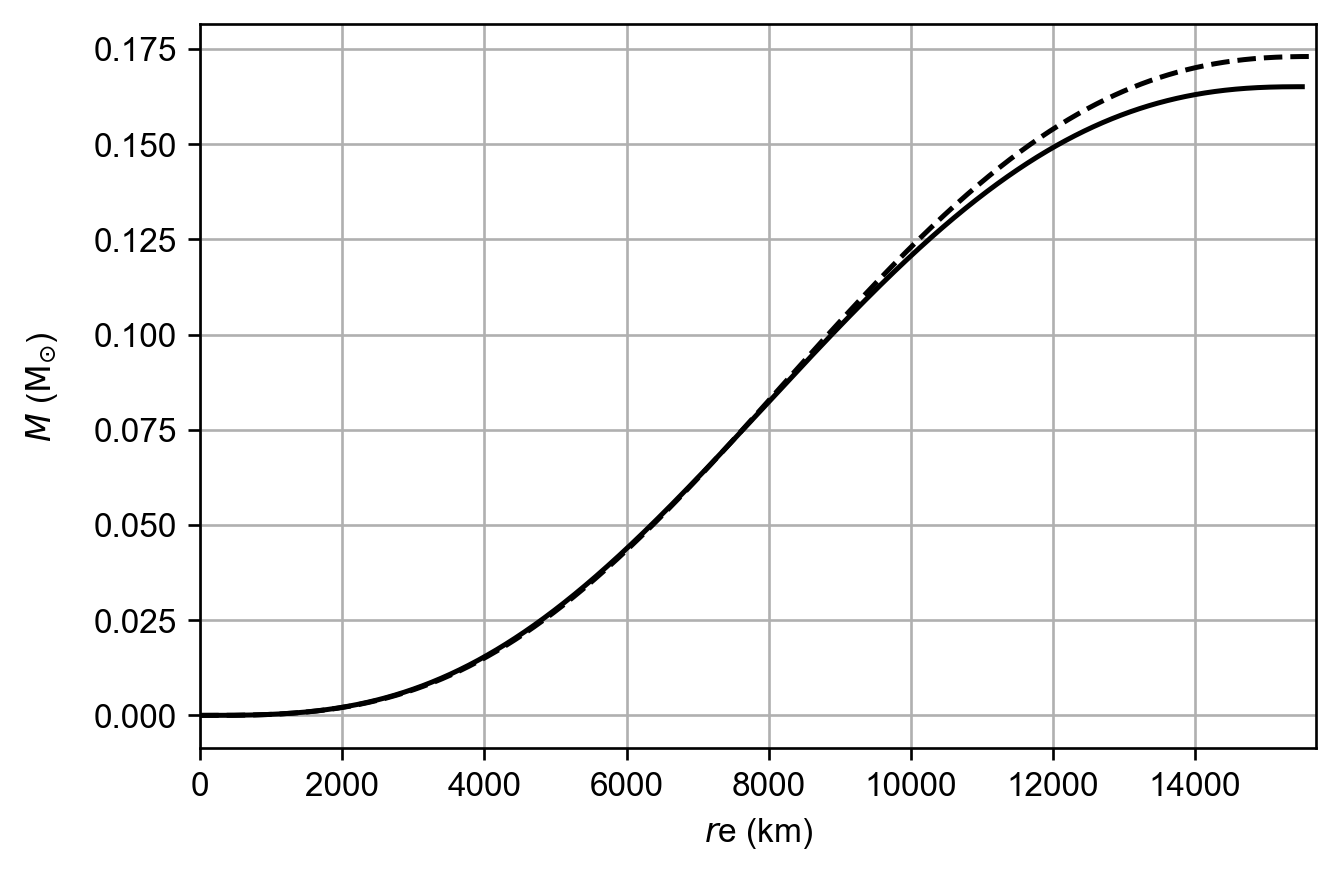

In [12]:
"""
Now to plot our results:
"""


display(Latex("The radius of the star is ${0:5.2f}$ $ \\mathrm{{km}}$.".format(r_values[-1]/1000)))
display(Latex("The mass of the star is ${0:5.4f}$ $\mathrm{{M}}_{{\\odot}}$.".format(M_values[-1])))

display(Latex("The radius of the star is ${0:5.2f}$ $ \\mathrm{{km}}$.".format(r_values_2[-1]/1000)))
display(Latex("The mass of the star is ${0:5.4f}$ $\mathrm{{M}}_{{\\odot}}$.".format(M_values_2[-1])))

fig1 = plt.figure(dpi = 250)
ax1 = fig1.add_subplot(111)
#ax1.set_ylim(bottom = 0., top = 1.1)
ax1.plot(r_values/1000, p_values, color = 'k', linestyle = '-', label = "Full EoS")
ax1.plot(r_values_2/1000, p_values_2, color = 'k', linestyle = '--', label = "Polytrope")
ax1.set_xlabel("$r$ (km)", fontsize = "large")
ax1.set_ylabel("$p(r)$ ($\\mathrm{{Pa}}$)", labelpad = 15)
ax1.margins(x = 0)
ax1.grid()

fig2 = plt.figure(dpi = 240)
ax2 = fig2.add_subplot(111)
#ax2.set_xlim(left = 0., right = 1.01)
#ax2.set_ylim(bottom = 0., top = 1.1)
ax2.plot(r_values/1000, M_values, color = 'k', linestyle = '-', label = "Full EoS")
ax2.plot(r_values_2/1000, M_values_2, color = 'k', linestyle = '--', label = "Polytrope")
ax2.set_xlabel("$r$e (km)")
ax2.set_ylabel("$M$ ($\\rm{{M}}_{{\\odot}}}}$)", labelpad = 10)
ax2.margins(x = 0)
ax2.grid()
plt.savefig("Figures/Test figure.pdf")

plt.show()

In [11]:
print(epsilon_polytrope(1e-20))
print(epsilon_smooth(60039151396277.97))

4.868940863407569e-06
2.1120806760563653e+21
